# Import Libraries

In [257]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import Data from .csv

In [258]:
df_raw = pd.read_csv(r'C:\Users\zhaor\OneDrive - McMaster University\COMPSCI 4AL3\Final Project\NY-electricity-load-prediction\data\Prepared data\2020_features.csv')
df_raw.head()

,timestamp,load,weathertime,temp,wspd,pressure,precip_hrly,dow,doy,day,month,hour,minute,year
0,2020-01-01 00:00:00,1208.4,2020-01-01 00:51:00,40,14.0,29.63,0.0,2,1,1,1,0,0,2020
1,2020-01-01 00:05:00,1191.0,2020-01-01 00:51:00,40,14.0,29.63,0.0,2,1,1,1,0,5,2020
2,2020-01-01 00:10:00,1195.5,2020-01-01 00:51:00,40,14.0,29.63,0.0,2,1,1,1,0,10,2020
3,2020-01-01 00:15:00,1210.9,2020-01-01 00:51:00,40,14.0,29.63,0.0,2,1,1,1,0,15,2020
4,2020-01-01 00:20:00,1186.3,2020-01-01 00:51:00,40,14.0,29.63,0.0,2,1,1,1,0,20,2020


# Add Day Type (weekday, weekend, holiday)

In [259]:
import datetime
import holidays

def is_workday(date:datetime.date):
    """
    Determines the type of day (workday or not) for a given date.

    Args:
        date (datetime.date): The date to check.

    Returns:
        int: 1 if workday else 0.
    """
    # Get the US holidays
    us_holidays = holidays.US()

    # Check if the date is a holiday
    if date in us_holidays:
        return 0

    # Check if the date is a weekend
    if date.weekday() >= 5:  # Saturday is 5, Sunday is 6
        return 0

    # Otherwise, it's a weekday
    return 1


In [260]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class TimestampTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        X['timestamp'] = pd.to_datetime(X['timestamp'])
        X['is_workday'] = X['timestamp'].apply(lambda x: is_workday(x.date()))
        X['month'] = X['timestamp'].dt.month
        X['day'] = X['timestamp'].dt.day
        X['hour'] = X['timestamp'].dt.hour
        X = X.drop('timestamp', axis=1)
        return X

In [261]:
df = df_raw[['timestamp', 'load', 'temp']].copy()
del df_raw

# Data Preprossing

In [262]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

timestamp_transformer = TimestampTransformer()
df = timestamp_transformer.transform(df)
scaler_temp = StandardScaler()
scaler_load = StandardScaler()
df['temp'] = scaler_temp.fit_transform(df[['temp']])
df['load'] = scaler_load.fit_transform(df[['load']])

# Make Dataset

In [263]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose

class TimeSeriesDataset(Dataset):
    def __init__(self, df, seq_len, transform=None, target_transform=None):
        """
        Custom Dataset for multivariate time series.

        Args:
            df (pd.Dataframe): Assume the dataframe has been preprocessed and has only numeriacal values.
            seq_length (int): Length of each sequence.
            transform: Composition of transformations.
        """
        super(TimeSeriesDataset, self).__init__()
        self.df = df
        self.features = self.df.values
        self.targets = self.df['load'].values
        self.seq_len = seq_len
        # self.transform = transform
        # self.target_transform = target_transform
    
    def __len__(self):
        return len(self.features) - self.seq_len
    
    def __getitem__(self, idx):
        sequence = self.features[idx:idx + self.seq_len, :]
        sequence = torch.tensor(sequence, dtype=torch.float32)
        target = self.targets[idx + self.seq_len]
        target = torch.tensor(target, dtype=torch.float32)
        # if self.transform:
        #     sequence = self.transform(sequence)
        # if self.target_transform:
        #     target = self.target_transform(target)
        return sequence, target

In [264]:
import numpy as np

dataset = TimeSeriesDataset(df, seq_len=64)
train_size = int(0.8 * len(dataset))
train_dataset = torch.utils.data.Subset(dataset, range(train_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

# Make Dataloader

In [266]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=8, pin_memory=True)

# Model Implementation

In [267]:
import torch.nn as nn
import torch.nn.functional as F

import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out



# Training

In [268]:
def model_evaluation(model, criterion, data_loader, device='cuda'):

    batch_losses = []

    model.eval() # switch to evalution mode
    with torch.no_grad():
        for inputs, labels in data_loader:

            # move to GPU
            if torch.cuda.is_available():
                inputs = inputs.to(device)
                labels = labels.to(device)

            outputs = model(inputs)
            labels = labels.unsqueeze(1)
            # compute loss for this batch
            loss = criterion(outputs, labels)
            batch_losses.append(loss.item())

    model.train() # switch to training mode

    loss_mean = np.mean(batch_losses)

    return loss_mean

def training_loop(n_epochs, optimizer, model, criterion, train_loader, test_loader, verbose=False, device='cuda'):
    '''
    Return
    ------
    
    - train_loss
    - test_loss
    '''
    train_losses = []
    test_losses = []

    for n in range(n_epochs):

        for x_batch, y_batch in train_loader:
            # move to GPU
            if torch.cuda.is_available():
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

            outputs = model(x_batch)
            
            y_batch = y_batch.unsqueeze(1)

            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_loss = model_evaluation(model, criterion, train_loader)
        test_loss = model_evaluation(model, criterion, test_loader)

        if ((n + 1) % 10 == 0) or verbose:
            print(f'Epoch {n + 1}/{n_epochs}: Training loss {train_loss:.4f}, Validation Loss {test_loss:.4f}')
            print('----------------------------------------------------------')

        train_losses.append(train_loss)
        test_losses.append(test_loss)

    return train_losses, test_losses

In [ ]:
input_size = 6  # Number of features
hidden_size = 64
num_layers = 2
num_epochs = 50

model = SimpleRNN(input_size, hidden_size, num_layers).to('cuda')
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = training_loop(num_epochs, optimizer, model, criterion, train_loader, test_loader, verbose=True)

# Make Predictions

We will make predictions using 2020 data. 

In [ ]:
# get 2021 data
df_2021 = pd.read_csv(r'C:\Users\zhaor\OneDrive - McMaster University\COMPSCI 4AL3\Final Project\NY-electricity-load-prediction\data\Prepared data\2021_features.csv')

df_2021['temp'] = scaler_temp.transform(df_2021['temp'])
df_2021['load'] = scaler_load.transform(df_2021['load'])

In [255]:
def make_predictions(model, initial_data, future_data, device='cuda'):
    '''
    Make multi-step predictions based on the length of future_data.

    Parameters
    ----------
    model: Assume trained.
    initial_data (pd.Dataframe): The data to start the prediction. Assume data is normalized.
    future_data (pd.Dataframe): Has 'load', 'temp', 'is_workday', 'month', 'day', 'hour' columns. Assume data is normalized.

    Returns
    -------
    predictions (list): List of predictions (normalized).
    '''
    
    initial_data = torch.tensor(initial_data.values, dtype=torch.float32).to(device)
    future_data = torch.tensor(future_data.values, dtype=torch.float32).to(device)

    predictions = []

    with torch.no_grad():
        sequence = initial_data
        for i in range(len(future_data)):
            # make prediction
            print(sequence.unsqueeze(0))
            next_load = model(sequence.unsqueeze(0))
            print(next_load)
            predictions.append(next_load.item())
            # combine with future data
            next_data = torch.cat([next_load, future_data[i, 1:].unsqueeze(0)], 1)
            # update sequence
            sequence = torch.cat([sequence[1:], next_data], 0)
    
    return predictions

In [ ]:
initial_data = df.iloc[-64:]
future_data = df_2021.iloc[:64]

predictions = make_predictions(model, initial_data, future_data, device='cuda')

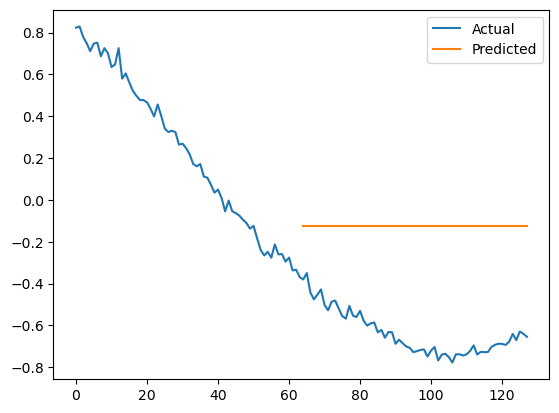

In [ ]:
# plot actual vs predicted
import matplotlib.pyplot as plt

# combine last 64 time steps in 2020 and first 64 time steps in 2021
initial = initial_data['load'].iloc[-64:].values
future = future_data['load'].iloc[:64].values
actual = np.concatenate([initial, future])

plt.plot(actual, label='Actual')
# shift the predictions to align with the actual data
plt.plot([None]*64 + predictions, label='Predicted')
plt.legend()
plt.show()